# plaqueuqalp: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022  
  
This is a code supporting the corresponding paper.

Packages import:

In [1]:
import os
import numpy as np
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
import pandas as pd

import albumentations as A

import SimpleITK as sitk

plt.style.use("ggplot")

Using TensorFlow backend.
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from keras.losses import binary_crossentropy

In [3]:
from scipy.ndimage import distance_transform_edt as distance

GPU assignment:

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2,3'                        
import tensorflow as tf
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

W0916 18:13:01.544868 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0916 18:13:01.546868 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0916 18:13:01.548869 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0916 18:13:08.413105 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

## 1. Data load

In [5]:
im_height = 512
im_width = 256

Getting image/contour names:

In [6]:
images = glob.glob('../data/*/T1W_*.dcm')
contours = glob.glob('../data/*/MASSExport/*.dcm')

Number of image/contour files:

In [7]:
len(images), len(contours)

(2739, 2739)

In [8]:
sub_names_list = []
for image in images:
    sub_name = image.split(os.sep)[1].split('_')[0]
    sub_names_list.append(sub_name)
        
sub_names = np.unique(sub_names_list)

Splitting subs into centers:

In [9]:
sub_names_amc = []
sub_names_mumc = []
sub_names_umcu = []
sub_names_emc = []

for sub_name in sub_names:
    if 'AMC' in sub_name:
        sub_names_amc.append(sub_name)
    if 'MUMC' in sub_name:
        sub_names_mumc.append(sub_name)
    if 'UMCU' in sub_name:
        sub_names_umcu.append(sub_name)
    if 'EMC' in sub_name:
        sub_names_emc.append(sub_name)
        
print (len(sub_names_amc), len(sub_names_mumc), len(sub_names_umcu), len(sub_names_emc))

13 115 25 34


Data split for training, validation, and testing stratified per center:

In [10]:
sub_names_amc_train, sub_names_amc_valid_test = train_test_split(sub_names_amc, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_amc_valid, sub_names_amc_test = train_test_split(sub_names_amc_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

sub_names_mumc_train, sub_names_mumc_valid_test = train_test_split(sub_names_mumc, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_mumc_valid, sub_names_mumc_test = train_test_split(sub_names_mumc_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

sub_names_umcu_train, sub_names_umcu_valid_test = train_test_split(sub_names_umcu, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_umcu_valid, sub_names_umcu_test = train_test_split(sub_names_umcu_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

sub_names_train = sub_names_amc_train + sub_names_mumc_train + sub_names_umcu_train
sub_names_valid = sub_names_amc_valid + sub_names_mumc_valid + sub_names_umcu_valid
sub_names_test = sub_names_amc_test + sub_names_mumc_test + sub_names_umcu_test

print (len(sub_names_amc_train), len(sub_names_mumc_train), len(sub_names_umcu_train))
print (len(sub_names_amc_valid), len(sub_names_mumc_valid), len(sub_names_umcu_valid))
print (len(sub_names_amc_test), len(sub_names_mumc_test), len(sub_names_umcu_test))
print (len(sub_names_emc))

9 80 17
2 17 4
2 18 4
34


Number of patients in training, validation, and testing subsets per center:

|DS | Total  | Train    | Valid   | Test   | Ext test |
|---:|:-------------|:-----------|:------|:------|:-----|
| AMC | 13  | 9 | 2   | 2     |0|
| MUMC | 115  | 80    | 17   | 18     |0|
| UMCU | 25  | 17    | 4   | 4     |0|  
| EMC | 34|0|0|0|34|
| Total | 187  | 106    | 23   | 24     |34|

Getting .dcm files for every subset:

In [11]:
img_names_train = []
img_names_valid = []
img_names_test = []

for sub_name_train in sub_names_train:
    img_names_train.extend(glob.glob('../data/'+sub_name_train+'*/T1W_*.dcm'))

for sub_name_valid in sub_names_valid:
    img_names_valid.extend(glob.glob('../data/'+sub_name_valid+'*/T1W_*.dcm'))
    
for sub_name_test in sub_names_test:
    img_names_test.extend(glob.glob('../data/'+sub_name_test+'*/T1W_*.dcm'))
    
print (len(img_names_train), len(img_names_valid), len(img_names_test))

1539 339 350


In [12]:
img_names_emc = []

for sub_name_emc in sub_names_emc:
    img_names_emc.extend(glob.glob('../data/'+sub_name_emc+'*/T1W_*.dcm'))
    
len(img_names_emc)

511

In [13]:
# read DICOM from path to array

def path2array(dcm_path):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    return arr

In [14]:
# image pre-processing: N4 bias field correction

def correctBiasField(img_input):
    
    corrected = False
    img_output = np.zeros(img_input.shape)

    while not corrected:

        try:
            corrector = sitk.N4BiasFieldCorrectionImageFilter()
            inputImage = sitk.GetImageFromArray(img_input)
            inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
            output = corrector.Execute(inputImage)
            img_output = sitk.GetArrayFromImage(output)
            corrected = True
        except:
            print ('BFC failed')

    return img_output

In [15]:
def half_slice(img, con, impth, crop = True):
    
    dim = img.shape
    
    con_output = np.zeros((im_height, im_width), dtype = np.uint8)
    img_output = np.zeros((im_height, im_width), dtype = np.uint8)
    
    if crop:
        img = img.copy()[8:-8, 8:-8]
        con = con.copy()[8:-8, 8:-8]
    
    con_1 = con[:, :con.shape[1]//2].copy()
    con_2 = con[:, con.shape[1]//2:].copy()
    
    img_1 = img[:, :img.shape[1]//2].copy()
    img_2 = img[:, img.shape[1]//2:].copy()
    
    if (np.sum(con_1)>0)&(np.sum(con_2)>0):
        print (impth)
    elif np.sum(con_1)>0:
        con_output = con_1
        img_output = img_1
    elif np.sum(con_2)>0:
        con_output = np.fliplr(con_2)
        img_output = np.fliplr(img_2)
        
    return img_output, con_output

In [16]:
# aggregation of the training patches from the corresponding DICOM paths

def paths2dataarray(paths_list, X_array, y_array):
    
    i = 0

    for impth in paths_list:

        img = path2array(impth)
        con_name = glob.glob(os.path.join(os.path.split(impth)[0],'MASSExport')+os.sep+'*'+ impth.split(os.sep)[2][-10:-4]+'*.dcm')[0]
        con = path2array(con_name)
        
        img_half, con_half = half_slice(img, con, impth)
        
        img_min = np.min(img_half)
        img_max = np.max(img_half)

        if (np.sum(con)>0)&((img_max - img_min)>0):
            
            img_half_norm = np.copy((img_half - img_min)/(img_max - img_min)*255).astype(np.uint8)

            X_array[i, ..., 0] = img_half_norm
            y_array[i, ..., 0] = con_half>0

            i+=1
            
    print (i, X_array.shape)

    

In [17]:
def paths2check(paths_list):
    
    i = 0

    for impth in paths_list:
        
        j = 1

        img = path2array(impth)
        con_name = glob.glob(os.path.join(os.path.split(impth)[0],'MASSExport')+os.sep+'*'+ impth.split(os.sep)[2][-10:-4]+'*.dcm')[0]
        con = path2array(con_name)
        
        img_half, con_half = half_slice(img, con, impth)
        
        img_min = np.min(img_half)
        img_max = np.max(img_half)

        if (np.sum(con_half)<=0):
            print ('CON', con_name)
            j = 0
            
        if (img_max - img_min)<=0:
            print ('IMG', impth)
            j = 0
            
        img_half_norm = np.copy((img_half - img_min)/(img_max - img_min)*255).astype(np.uint8)
        if np.sum(img_half_norm)<=0:
            print ('IMGNORM', impth)
            j = 0
            
        i+=j
            
    return i

In [18]:
print ('train')
len_train = paths2check(img_names_train)
print ('valid')
len_valid = paths2check(img_names_valid)
print ('test')
len_test = paths2check(img_names_test)

train
valid
test


In [19]:
print (len_train, len_valid, len_test)

1539 339 350


In [20]:
# empty arrays for training data

X_train = np.zeros((len_train, im_height, im_width, 1), dtype = np.uint8)
y_train = np.zeros((len_train, im_height, im_width, 1), dtype = np.uint8)
r_train = np.zeros(len_train, dtype = np.uint8)

X_valid = np.zeros((len_valid, im_height, im_width, 1), dtype = np.uint8)
y_valid = np.zeros((len_valid, im_height, im_width, 1), dtype = np.uint8)
r_valid = np.zeros(len_valid, dtype = np.uint8)

X_test = np.zeros((len_test, im_height, im_width, 1), dtype = np.uint8)
y_test = np.zeros((len_test, im_height, im_width, 1), dtype = np.uint8)
r_test = np.zeros(len_test, dtype = np.uint8)

In [21]:
# aggregation of the training, validation, and testing patches
print ('train')
paths2dataarray(img_names_train, X_train, y_train)
print ('valid')
paths2dataarray(img_names_valid, X_valid, y_valid)
print ('test')
paths2dataarray(img_names_test, X_test, y_test)

train
1539 (1539, 512, 256, 1)
valid
339 (339, 512, 256, 1)
test
350 (350, 512, 256, 1)


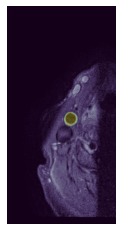

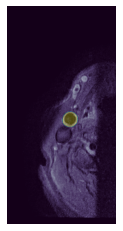

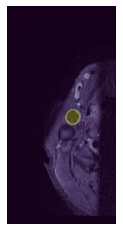

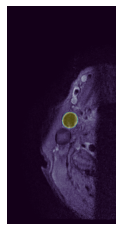

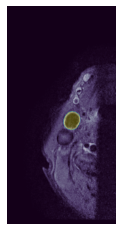

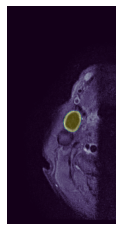

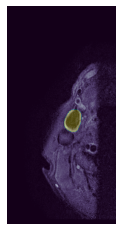

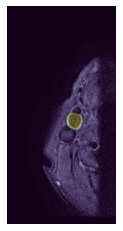

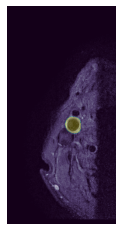

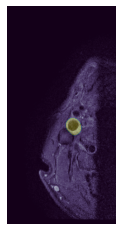

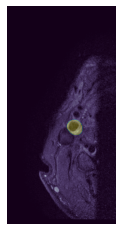

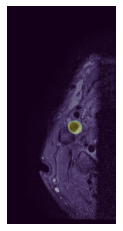

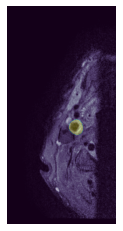

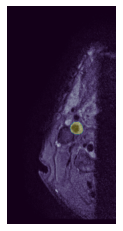

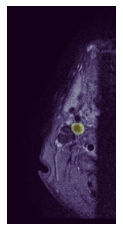

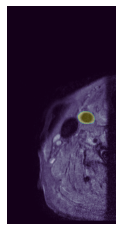

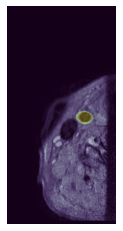

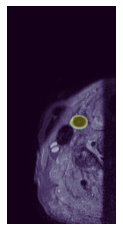

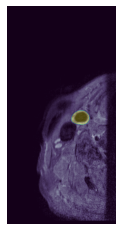

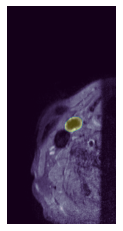

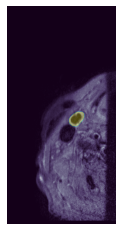

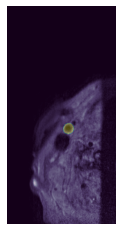

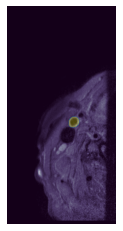

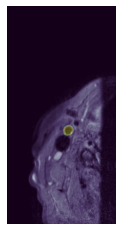

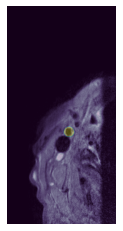

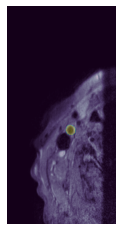

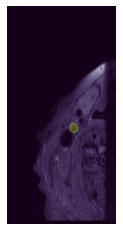

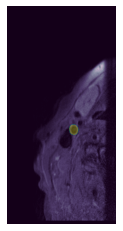

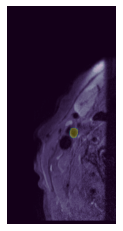

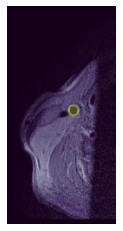

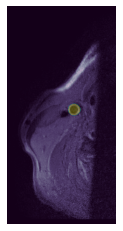

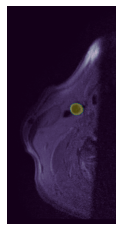

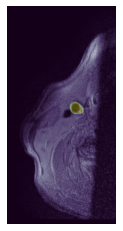

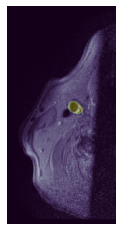

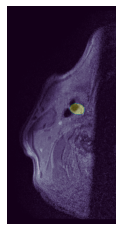

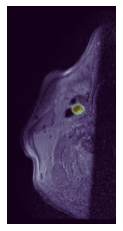

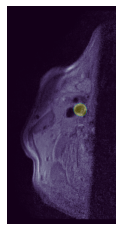

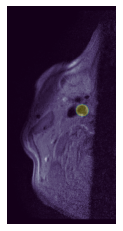

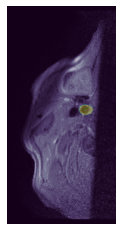

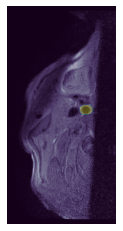

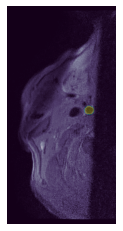

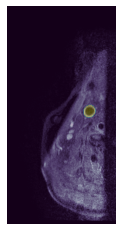

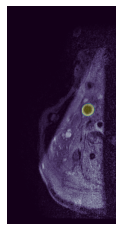

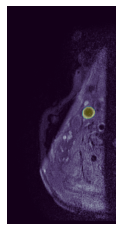

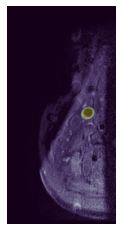

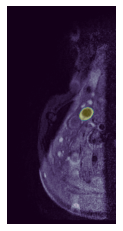

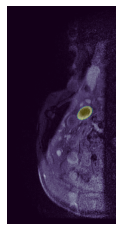

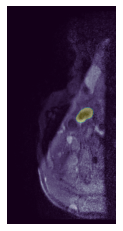

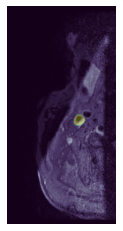

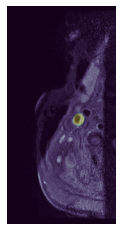

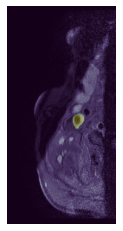

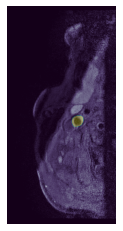

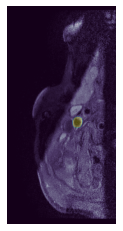

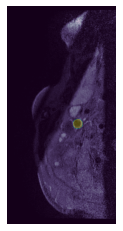

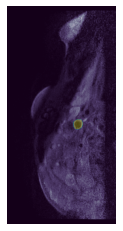

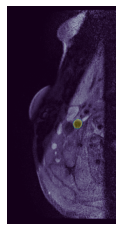

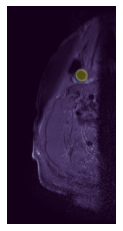

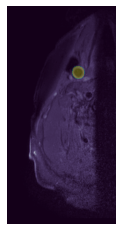

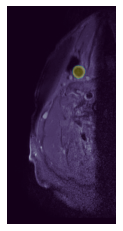

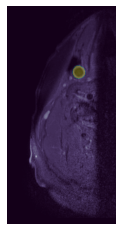

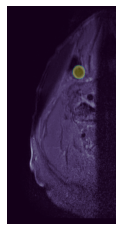

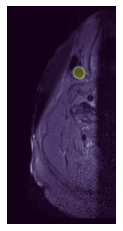

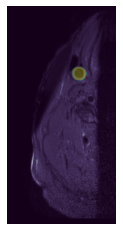

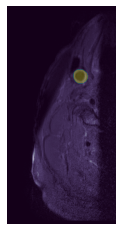

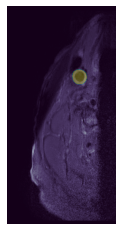

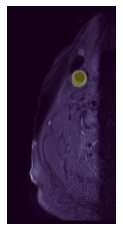

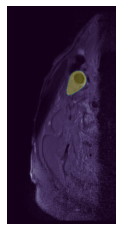

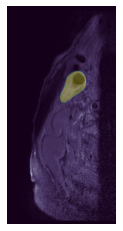

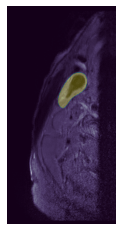

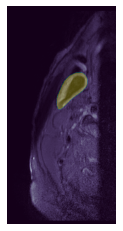

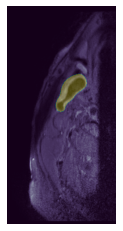

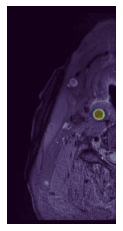

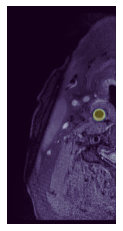

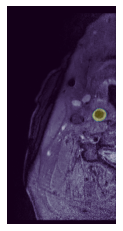

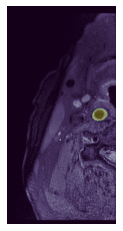

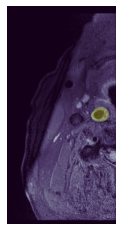

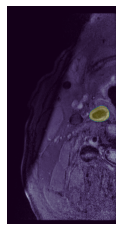

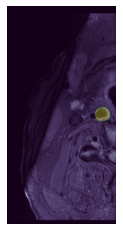

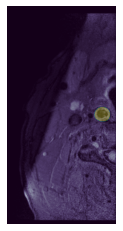

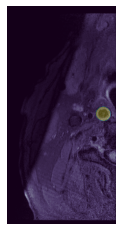

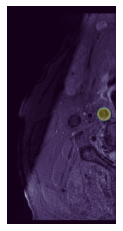

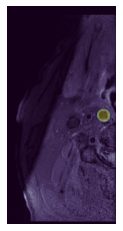

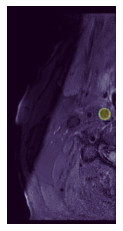

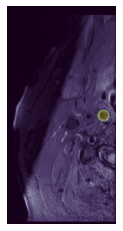

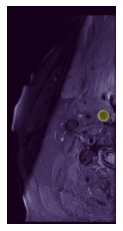

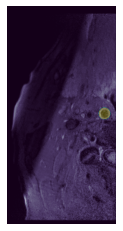

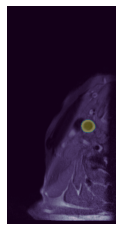

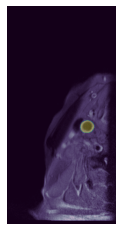

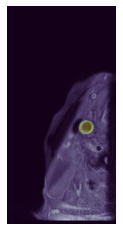

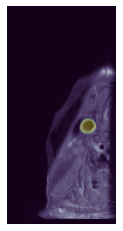

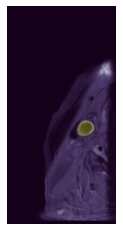

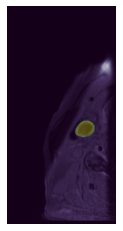

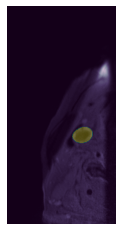

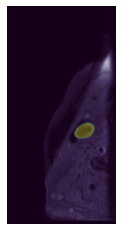

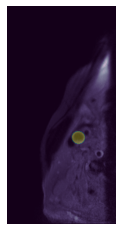

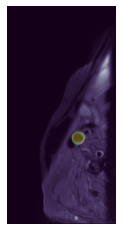

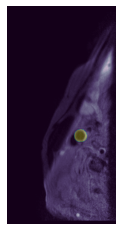

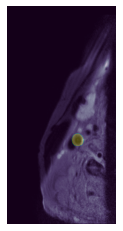

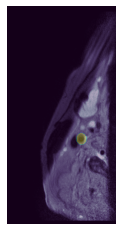

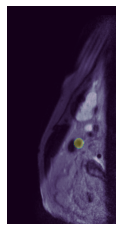

In [22]:
# visualization of the training patches

for i in range (0, 100):
    plt.imshow(X_train[i, ..., 0], cmap = 'bone')
    plt.imshow(y_train[i, ..., 0], alpha = 0.3)
    plt.axis('Off')
    plt.show()

## 2. Data augmentation

Defining transformations:

In [23]:
transform = A.Compose([    
    A.Blur(blur_limit=4, p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.RandomGamma(p=0.5),
    #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7, border_mode=cv2.BORDER_REPLICATE)
])

Generation of the augmented patches:

In [ ]:
# n_augms random transformations of the images X and masks y

def augment_ds(X, y, n_augms):
    
    counter = 0
    dim = y[0, ..., 0].shape
    n_samples = y.shape[0]
    
    X_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 1), dtype = np.uint8)
    y_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 1), dtype = np.uint8)
    
    for smpl in range (0, n_samples):
        for augm in range (0, n_augms):
            
            random.seed(counter)
            augmented = transform(image=X[smpl, ..., 0], mask=y[smpl, ..., 0])
            X_aug[augm*n_samples+smpl, ..., 0] = augmented['image']
            y_aug[augm*n_samples+smpl, ..., 0] = augmented['mask']
            #counter += 1
            
    return X_aug, y_aug    

Writing augmented data into arrays:

In [ ]:
X_train_aug, y_train_aug = augment_ds(X_train, y_train, 10)
X_valid_aug, y_valid_aug = augment_ds(X_valid, y_valid, 10)

Visualization of the transformed images:

In [ ]:
#for n_sample in range (0, 336):
    
    #plt.figure(figsize=(10,10))
    #plt.subplot(121)
    #plt.imshow(X_valid[n_sample, ..., 0])
    #plt.contour(y_valid[n_sample, ..., 0], colors='r')
    #plt.subplot(122)
    #plt.imshow(X_valid_aug[n_sample, ..., 0])
    #plt.contour(y_valid_aug[n_sample, ..., 0], colors='r')
    #plt.show()

## 3. U-Net construction

Defining blocks:

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('elu')(x)

    return x

def get_unet(input_img, n_filters = 8, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Custom scores:

In [ ]:
def dice_coef(y_true, y_pred):
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def custom_loss(y_true, y_pred):
    
    return 0.5*keras.losses.binary_crossentropy(y_true,y_pred)+0.5*dice_loss(y_true,y_pred)

In [ ]:
def calc_dist_map(seg):
    res = np.zeros_like(seg, dtype=np.float64)
    posmask = seg.astype(np.bool)
    
    negmask = ~posmask
    res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).reshape(y_true.shape).astype(np.float16)


def surface_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch, inp=[y_true], Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

In [ ]:
def loss_wrapper(current_epoch):
    def mixed_loss(y_true, y_pred):
        step = 0.01
        loss_1 = custom_loss(y_true, y_pred)
        loss_2 = surface_loss(y_true, y_pred)
        loss = (1-step*current_epoch)*loss_1 + step*current_epoch*loss_2
        return loss
    return mixed_loss

In [ ]:
current_epoch = K.variable(0.)

Model compilation:

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')

#model_simple = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
#model_simple.compile(optimizer=Adam(), loss=loss_wrapper(current_epoch), metrics=[dice_coef])
#model_simple.summary()

model_aug = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_aug.compile(optimizer=Adam(), loss=loss_wrapper(current_epoch), metrics=[dice_coef])
model_aug.summary()

W0916 18:18:56.074838 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 18:18:56.080837 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 18:18:56.082837 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0916 18:18:56.116835 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0916 18:18:56.1

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 512, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 512, 256, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

Callbacks:

In [ ]:
class NewCallback(Callback):
    def __init__(self, current_epoch):
        self.current_epoch = current_epoch

    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.current_epoch, epoch)

In [ ]:
#callbacks_simple = [
#    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
#    ModelCheckpoint('../res/plaqueuqalp_simple_dtm.h5', verbose=1, save_best_only=True, save_weights_only=True),
#    NewCallback(current_epoch)
#]

callbacks_aug = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('../res/plaqueuqalp_aug_dtm.h5', verbose=1, save_best_only=True, save_weights_only=True),
    NewCallback(current_epoch)
]

In [ ]:
np.unique(y_valid_aug)

array([0, 1], dtype=uint8)

In [ ]:
np.sum(y_valid_aug[:, 0, :, 0])

0

In [ ]:
np.sum(y_valid_aug[:, -1, :, 0])

0

In [ ]:
np.sum(y_valid_aug[:, :, 0, 0])

0

In [ ]:
np.sum(y_valid_aug[:, :, -1, 0])

0

In [ ]:
from skimage import measure

In [ ]:
for item in y_valid_aug:
    labels = measure.label(item[..., 0])
    if (np.max(labels)>1):
        print ('A')

In [ ]:
for item in y_valid_aug:
    if (np.sum(item)==0):
        print ('A')

In [ ]:
for item in y_valid_aug:
    if (np.sum(item-1)==0):
        print ('A')

## 4. Model training with and without augmentation

Models training (with and w/o augmentation):

In [ ]:
# simple model (w/o data augmentation)

#results_simple = model_simple.fit(X_train, y_train,
#                                  batch_size=16, epochs=100, 
#                                  callbacks=callbacks_simple, 
#                                  validation_data=(X_valid, y_valid))

In [ ]:
# data augmentation

results_aug = model_aug.fit(X_train_aug, y_train_aug,
                            batch_size=16, 
                            epochs=100, 
                            callbacks=callbacks_aug, 
                            validation_data=(X_valid_aug, y_valid_aug))

W0916 18:19:30.467908 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0916 18:19:31.298952 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0916 18:19:32.210851 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



Train on 15390 samples, validate on 3390 samples
Epoch 1/100


W0916 18:19:33.932784 44908 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


13312/15390 [========================>.....] - ETA: 3:07 - loss: 0.3304 - dice_coef: 0.4495

In [ ]:
#model_aug.compile(optimizer=Adam(), loss=surface_loss, metrics=[dice_coef])

In [ ]:
#results_aug = model_aug.fit(X_train, y_train,
#                            batch_size=32, epochs=50, 
#                            callbacks=callbacks_aug, 
#                            validation_data=(X_valid, y_valid))

Learning curves visualization:

In [ ]:
# simple model

#plt.figure(figsize=(8, 8))
#plt.title("Learning curve (simple model)")
#plt.plot(results_simple.history["loss"], label="loss")
#plt.plot(results_simple.history["val_loss"], label="val_loss")
#plt.plot( np.argmin(results_simple.history["val_loss"]), np.min(results_simple.history["val_loss"]), 
#         marker="x", color="r", label="best model")
#plt.xlabel("Epochs")
#plt.ylabel("loss")
#plt.legend();

In [ ]:
# augmented model

plt.figure(figsize=(8, 8))
plt.title("Learning curve (augmented model)")
plt.plot(results_aug.history["loss"], label="loss")
plt.plot(results_aug.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_aug.history["val_loss"]), np.min(results_aug.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

## 5. Models performance on patches

Loading weights:

In [ ]:
model_simple.load_weights('../res/plaqueuqalp_simple_sl.h5')
model_aug.load_weights('../res/plaqueuqalp_simple_sl.h5')

Evaluating on the PATCHES of the validation set:

In [ ]:
# simple model

model_simple.evaluate(X_valid, y_valid, verbose=1)

In [ ]:
# augmented model:

model_aug.evaluate(X_valid, y_valid, verbose=1)

Evaluation on the PATCHES of the test set:

In [ ]:
# simple model was .8

model_simple.evaluate(X_test, y_test, verbose=1)

In [ ]:
# augmented model was .8

model_aug.evaluate(X_test, y_test, verbose=1)

Predictions for the test set (+ thresholding):

In [ ]:
preds_test_simple = model_simple.predict(X_test, verbose=1)
preds_test_simple_t = (preds_test_simple > 0.5).astype(np.uint8)

preds_test_aug = model_aug.predict(X_test, verbose=1)
preds_test_aug_t = (preds_test_aug > 0.5).astype(np.uint8)

Visualization of the prediction:

In [ ]:
from matplotlib.patches import Patch
import matplotlib.font_manager as font_manager

In [ ]:
font = font_manager.FontProperties(family='Times New Roman', weight='ultralight', size='12')

In [ ]:
ix = 100

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0,0].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[0,0].contour(y_test[ix].squeeze(), colors='r', levels=[0.5], linewidths=3)
ax[0,0].set_title('GT')
ax[0,0].grid(False)

ax[0,1].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[0,1].contour(preds_test_simple_t[ix].squeeze(), colors='r', levels=[0.5], linewidths=3)
ax[0,1].set_title('Predicted (simple model)')
ax[0,1].grid(False)

ax[1,0].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[1,0].contour(preds_test_aug_t[ix].squeeze(), colors='r', levels=[0.5], linewidths=3)
ax[1,0].set_title('Predicted (augmented model)')
ax[1,0].grid(False)

ax[1,1].imshow(X_test[ix, ..., 0].squeeze())
ax[1,1].contour(preds_test_simple_t[ix].squeeze(), colors='red', levels=[0.5], linewidths=3)
ax[1,1].contour(preds_test_aug_t[ix].squeeze(), colors='yellow', levels=[0.5], linewidths=3)
ax[1,1].set_title('Simple vs augmented segmentation')
#legend_elements = [Patch(facecolor='red', label='Groundtruth'),
#                   Patch(facecolor='yellow', label='Autosegmentation')]
#ax[1,1].legend(handles=legend_elements, loc=4, prop=font)
ax[1,1].grid(False)